# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

In [1]:
import os
from glob import glob
import getpass
from tqdm import tqdm
import warnings

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

In [2]:
from moscatel import utils

bands = utils.get_band_list(file_list);

SyntaxError: invalid syntax (utils.py, line 29)

## Stack (some) raw images

In [5]:
from moscatel import utils

stacked_images = []
for key in sorted(bands.keys()):
    stacked_images.append(utils.stack_raw_images(bands[key], skip_every=10))

  2%|▏         | 15/704 [00:00<00:04, 147.29it/s]

number of stacked raw images=376


  2%|▏         | 6/376 [00:00<00:06, 57.55it/s]

number of stacked raw images=704


100%|██████████| 376/376 [00:03<00:00, 112.93it/s]


number of stacked raw images=376


## Detect point sources

In [6]:
from moscatel import phot
from tqdm import tqdm

sources = []

for idx, img in tqdm(enumerate(stacked_images)):
    sources.append(phot.get_sources(img, num_stars=10))

3it [00:03,  1.14s/it]


note that star 1 and 2 is different in g-band.

## aperture photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)


for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)


try `aperture_photometry( ... ,method='subpixel', subpixels=5)` for subpixel accucacy.

## try for g-band with 3 stars and 2 aperture radii

In [7]:
from moscatel import phot
from operator import itemgetter

centroids_g = list(zip(sources[0]['xcentroid'],sources[0]['ycentroid']))
centroids_r = list(zip(sources[1]['xcentroid'],sources[1]['ycentroid']))
centroids_z = list(zip(sources[2]['xcentroid'],sources[2]['ycentroid']))
centroids = [centroids_g,centroids_r,centroids_z]

band_idx = 0 #g,r,z
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
#star_positions=centroids[band_idx][:nstars]
star_positions=itemgetter(0,1,3)(centroids[band_idx])
radii =[8,15,20]
box_size = 40

tables_g=phot.make_lightcurve(bands['g'], star_positions, 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=20, r_out=40);

  0%|          | 0/376 [00:00<?, ?it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (702.89569058915913, 303.24546019686505)


  1%|          | 2/376 [00:00<00:34, 10.94it/s]


---------star index: 1---------
initial centroid: (914.98331267516869, 263.79361382872224)


  0%|          | 1/376 [00:00<00:38,  9.83it/s]


---------star index: 2---------
initial centroid: (143.81535718882839, 859.08520738678033)


  8%|▊         | 30/376 [00:03<00:40,  8.61it/s]/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 376/376 [00:47<00:00,  8.00it/s]

---------Done---------


In [8]:
#save as separate csv's per star
dfs_g=utils.parse_and_save_tables(tables_g, band_idx)

saved:
data/phot_gband_star0.csv
saved:
data/phot_gband_star1.csv
saved:
data/phot_gband_star2.csv


## Relative photometry

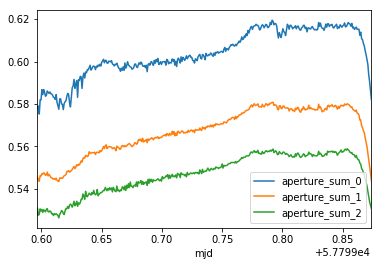

In [9]:
%matplotlib inline

param='aperture_sum_0,aperture_sum_1,aperture_sum_2'.split(',')
target_id=1
ref_id=0

t=dfs_g[target_id][param]
ref=dfs_g[ref_id][param]+dfs_g[2][param]

(t/ref).plot()

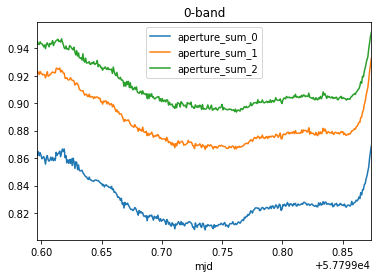

In [10]:
ref_id=2

t=dfs_g[target_id][param]
ref=dfs_g[0][param]

title='{}-band'.format(band_idx)
(t/ref).plot(title=title)

good apertures
* 10: flat right baseline, but slanting left baseline

good annulus
* 15-20

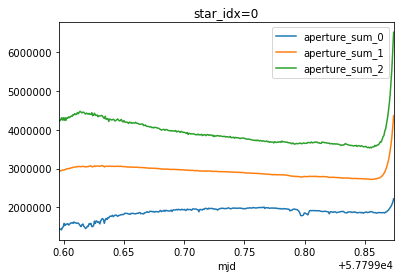

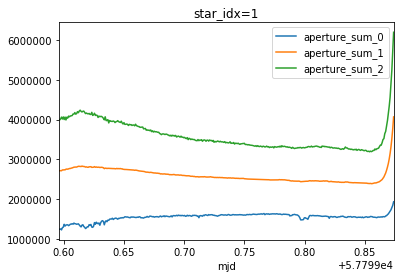

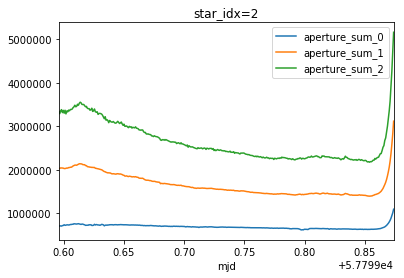

In [11]:
params = 'aperture_sum_0,aperture_sum_1,aperture_sum_2'.split(',')

for star_idx in range(nstars):
    title='star_idx={}'.format(star_idx)
    dfs_g[star_idx][params].plot(title=title)

## try for r-band with 3 stars and 2 aperture radii

In [12]:
band_idx = 1 #g,r,z

band=sorted(bands.keys())
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
#star_positions=centroids[band_idx][:nstars]
star_positions=itemgetter(0,1,3)(centroids[band_idx])
skip_every=1
radii =[8,12,16]
box_size = 40

tables_r=phot.make_lightcurve(bands[band[band_idx]], star_positions, 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=15, r_out=30);

  0%|          | 2/704 [00:00<01:03, 11.03it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (702.27508706034257, 301.04452095351655)


  0%|          | 2/704 [00:00<01:03, 11.06it/s]


---------star index: 1---------
initial centroid: (913.73255408431658, 258.52589130096993)


  0%|          | 1/704 [00:00<01:21,  8.65it/s]


---------star index: 2---------
initial centroid: (151.28539258434637, 864.68380318025584)


100%|██████████| 704/704 [01:31<00:00,  7.24it/s]

---------Done---------


In [13]:
dfs_r=utils.parse_and_save_tables(tables_r, band_idx)

saved:
data/phot_rband_star0.csv
saved:
data/phot_rband_star1.csv
saved:
data/phot_rband_star2.csv


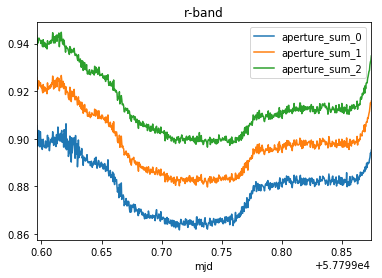

In [14]:
target_id=1
ref_id=0
param='aperture_sum_0,aperture_sum_1,aperture_sum_2'.split(',')


t=dfs_r[target_id][param]
ref=dfs_r[ref_id][param]

(t/ref).plot(title='r-band')

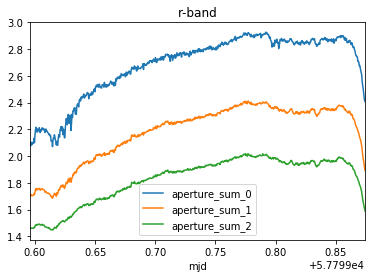

In [15]:
ref_id=2

t=dfs_r[target_id][param]
ref=dfs_r[ref_id][param]

(t/ref).plot(title='r-band')

good apertures
* 8: flat right baseline, but slanting left baseline

good annulus
* r_in=10, r_out=25
* 15, 30

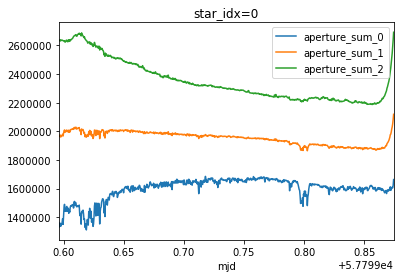

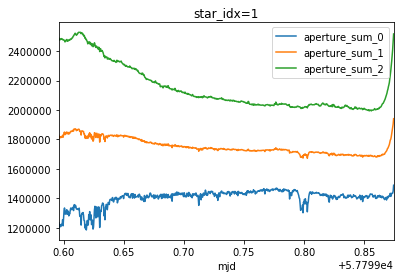

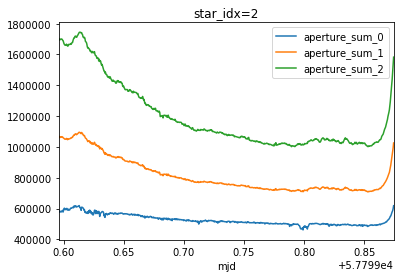

In [16]:
params='aperture_sum_0,aperture_sum_1,aperture_sum_2'.split(',')

for star_idx in range(nstars):
    title='star_idx={}'.format(star_idx)
    dfs_r[star_idx][params].plot(title=title)

## try for z-band with 3 stars and 2 aperture radii

In [18]:
band_idx = 2 #g,r,z
radii =[8,14,20]
#star_positions=centroids[band_idx][:nstars]
star_positions=itemgetter(0,1,2)(centroids[band_idx])

tables_z=phot.make_lightcurve(bands[band[band_idx]], star_positions, 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=20, r_out=40);
dfs_z=utils.parse_and_save_tables(tables_z, band_idx)


  0%|          | 1/376 [00:00<00:53,  6.97it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (699.57022728837183, 285.99607368257477)



  0%|          | 1/376 [00:00<00:53,  7.00it/s]


---------star index: 1---------
initial centroid: (911.39859728804333, 246.04366816591983)


  0%|          | 1/376 [00:00<00:42,  8.73it/s]


---------star index: 2---------
initial centroid: (704.22007897925596, 740.51054978181958)


100%|██████████| 376/376 [01:12<00:00,  4.49it/s]

---------Done---------
saved:
data/phot_z_sband_star0.csv
saved:
data/phot_z_sband_star1.csv
saved:
data/phot_z_sband_star2.csv


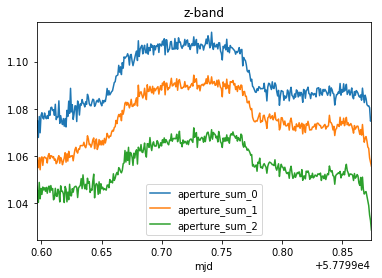

In [19]:
param='aperture_sum_0,aperture_sum_1,aperture_sum_2'.split(',')
target_id=1
ref_id=0

t=dfs_z[target_id][param]
ref=dfs_z[ref_id][param]

(t/ref).plot(title='z-band')

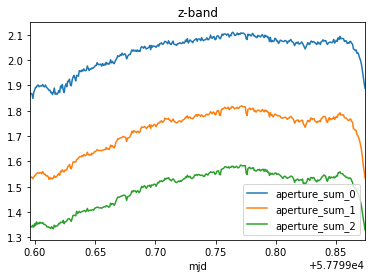

In [20]:
ref_id=2

t=dfs_z[target_id][param]
ref=dfs_z[ref_id][param]

(t/ref).plot(title='z-band')

good apertures
* 8: flat right baseline, but slanting left baseline

good annulus
* r_in=15, r_out=20,25

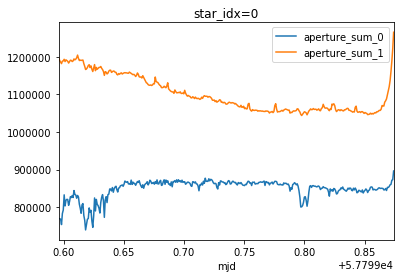

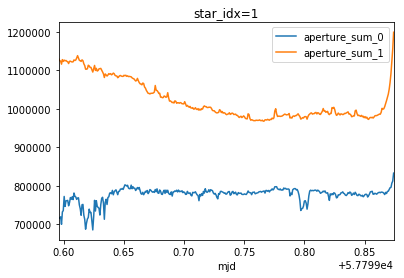

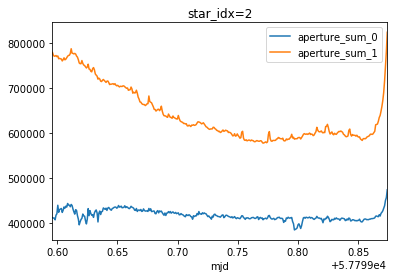

In [21]:
params = 'aperture_sum_0,aperture_sum_1'.split(',')

for star_idx in range(nstars):
    title='star_idx={}'.format(star_idx)
    dfs_z[star_idx][params].plot(title=title)

It takes 40 seconds on average per star per band. So for 3 stars per band, it takes about 3*3*40=240 sec=4 mins.

## To do

save in aperture radius in column header of df